# Anomaly Detection using LSTM Encoder-Decoder.

This is the fourth of four notebooks used in defining and training an encoder-decoder LSTM architecture for anomaly detection. Each of the following four steps are completed in an individual notebook:

- __Preprocess__: Preprocess raw ICEWS data into time series for training and evaluating a model.
- __Train__: Create and train a model with pre-processed and cleaned data.
- __Threshold calculation__: Use the residuals from a validation set to determine an anomaly detection threshold.
- __Inference__: Run anomaly detection on data from various countries to assess performance.

In this notebook we run AD on some specific countries. We hope to see that traditionally unstable countires are anomaly rich while stable countries show relatively few anomalies. 

In [9]:
import sys
sys.path.append('..')

import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

from util import data, metrics, preprocess, icews
from models import spot, networks

from statsmodels.distributions.empirical_distribution import ECDF

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

sns.set()
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 24
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load country data
In the below code we choose a country to run anomaly detection on. We will get that country's raw ICEWS data, process it into timeseries format and run it through our model.

In [10]:
country = 'Germany'

# Features to drop
drop = [
    'Event ID', 'ï»¿Event ID', 'Source Name', 'Source Sectors',
    'Source Country', 'CAMEO Code', 'Target Name', 'Target Sectors',
    'Target Country', 'Story ID', 'Sentence Number', 'Publisher',
    'City', 'District', 'Province', 'Country', 'Latitude', 'Longitude',
    'Event Text'
]

country_df = icews.get_country_df(country, 'data/icews/')
country_ts = icews.run(country_df, ['QuadClass'])

print(f'Percentage of days reported since 2014: {len(country_ts) / len(country_ts.asfreq("d"))}')

loading data/icews/icews_germany_raw.parquet... done.
Percentage of days reported since 2014: 0.9905474596297755


# Load pre-trained encoder/decoder
This step just requires knowing the number of features, sub-sequence length and embedding space the model was trained for. 

In [11]:
factor = 8
window = 7
n_features = 5 # Intensity, QC1, QC2, QC3, QC4
emb_size = window * n_features * factor

state_dict = torch.load(f'data/models/ae_lstm_mse_sum_{window}d_{factor}f.pt',
                       map_location=torch.device(device))

model = networks.LSTMEncoderDecoder(n_features, emb_size)
model.load_state_dict(state_dict)
model = model.to(device)

# Compute anomaly scores on data
Will now compute the country's reconstruction loss and from it derive an anomaly score. 

## Step 1: Get Encoder/Decoder Loss

In [12]:
trfm = preprocess.Difference()
test_set = data.TimeSeriesDataSet(country_ts, 
                                  window=7, 
                                  transform=trfm)

# Use dataloader to difference transform entire dataset in parallel. 
data_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)
model_input = iter(data_loader).next().float().to(device)

criterion = nn.L1Loss(reduction='none')
with torch.no_grad():
    loss = torch.tensor([]).to(device)
    for seq in model_input:
        seq = seq.unsqueeze(0)
        output = model(seq)
        seq_loss = criterion(output, seq)
        loss = torch.cat((loss, seq_loss))

loss = loss.view(-1, n_features).cpu().numpy()

### Step 2: Get Anomaly Scores from Loss

<AxesSubplot:ylabel='Count'>

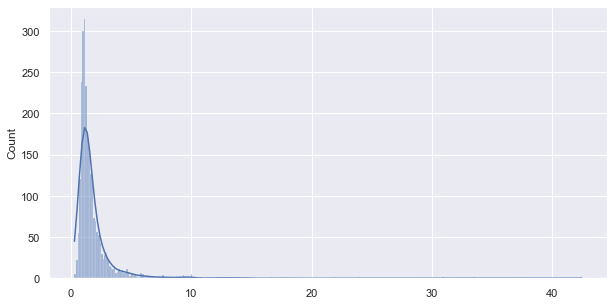

In [13]:
mu, sigma = joblib.load(f'data/models/mu_sigma_{window}d_{factor}f.joblib')
md = metrics.MahalaDistance(mu, sigma)
scores = md.measure(loss)

sns.histplot(data=scores, kde=True)

## Load the calculated threshold
We just load the anomaly score threshold calculated in the last notebook:

In [14]:
# Use simple CDF from "normal" scores to compute theshold t s.t. p(a > t) < 0.99
thresh = joblib.load(f'data/models/AD_threshold_{window}d_{factor}f.joblib')

## Collect data for visualization
Here we just pull together all of the results of the anomaly detection run. We'll create two views: one for the last year and one that shows the entire history.

In [15]:
# get date index from original time series and trim off remainder (truncated by windowing function)
rem = len(country_ts) % window
dates = country_ts.index[rem:]

# create anomaly dataframe
country_ts = country_ts.iloc[rem:]
country_ts['Week'] = np.array([[i] * window for i in range(len(scores) // 7)]).reshape(-1, 1)
country_ts['Score'] = scores
country_ts['Anomaly'] = country_ts['Score'].apply(lambda x: True if x > thresh else False)

# get last year's data for close up visualization.
last_year_ts = country_ts.iloc[-364:, :]

## Plotting the results:

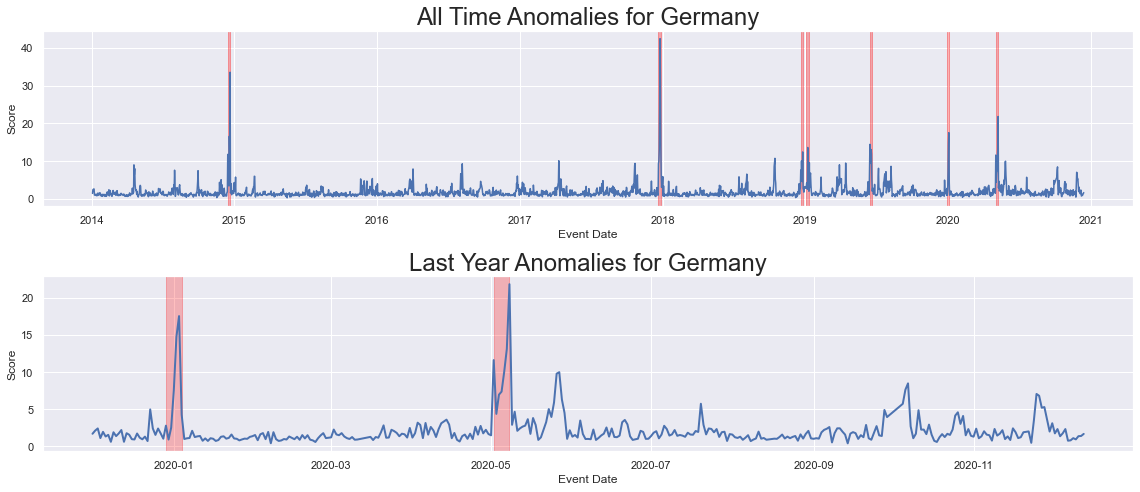

In [16]:
f, ax = plt.subplots(2, 1, figsize=(16,7))

# Highlight all weeks containing anomalies.
for w in country_ts.Week.unique():
    temp = country_ts[country_ts.Week == w]
    if (temp.Anomaly == True).any():
        ax[0].axvspan(temp.index[0], temp.index[-1], color='red', alpha=0.3)
        
# Highlight weeks during last year with anomalies.
for w in last_year_ts.Week.unique():
    temp = last_year_ts[last_year_ts.Week == w]
    if (temp.Anomaly == True).any():
        ax[1].axvspan(temp.index[0], temp.index[-1], color='red', alpha=0.25)


sns.lineplot(x=country_ts.index, y='Score', data=country_ts, ax=ax[0])
sns.lineplot(x=last_year_ts.index, y='Score', data=last_year_ts, ax=ax[1], linewidth=2)
ax[0].set_title(f'All Time Anomalies for {country}')
ax[1].set_title(f'Last Year Anomalies for {country}')

plt.tight_layout()
plt.show()